### How to run Metient-calibrate on a subset of real metastatic NSCLC patients (TRACERx)

**To run this notebook, you'll need metient installed:**
```bash
mamba create -n "met" python=3.8.8 ipython
mamba activate met
pip install metient
```

### Import libraries and setup paths

In [1]:
### Standard imports
import os
import sys
import pandas as pd

### Import metient
from metient import metient as met

### Setup paths
tracerx_dir = os.path.join(os.getcwd(), "metient", "data", "tracerx_nsclc")
# Path to where our clone trees are located (clustered with pyclone -> clone tree from pairtree)
clone_trees_dir = os.path.join(tracerx_dir, "orchard_trees", "pyclone_clustered")
# Path to where our tsvs are located
tsv_dir = os.path.join(tracerx_dir, "patient_data", "pyclone_clustered")

CUDA GPU: False


### An example of the expected tsv file format for patient CRUK0004
**The required columns are:**
`#sample_index, sample_label, anatomical_site_index, anatomical_site_label, character_index, character_label, ref, var`

In [2]:
pd.read_csv(os.path.join(tsv_dir, "CRUK0010_clustered_SNVs.tsv"), sep="\t").head()

,Unnamed: 0,#sample_index,sample_label,anatomical_site_index,anatomical_site_label,character_index,character_label,ref,var,ploidy,purity,sample_type,original_anatomical_site_label
0,0,0,CRUK0010_SU_FLN1,0,LN_SU_FLN1,0,LMTK2:7:97834765:C;MUS81:11:65628662:C;ERMP1:9...,17447,2523,1.900,0.250,metastasis,LN_SU_FLN1
1,1,1,CRUK0010_BR_LN1,1,metachronousMet_BR_LN1,0,LMTK2:7:97834765:C;MUS81:11:65628662:C;ERMP1:9...,12077,1627,2.000,0.250,metastasis,metachronousMet_BR_LN1
2,2,2,CRUK0010_BR_LN2,2,metachronousMet_BR_LN2,0,LMTK2:7:97834765:C;MUS81:11:65628662:C;ERMP1:9...,16622,1949,2.150,0.200,metastasis,metachronousMet_BR_LN2
3,3,3,CRUK0010_BR_LN3,3,metachronousMet_BR_LN3,0,LMTK2:7:97834765:C;MUS81:11:65628662:C;ERMP1:9...,16966,2300,2.200,0.220,metastasis,metachronousMet_BR_LN3
4,4,4,CRUK0010_SU_T1.R2;CRUK0010_SU_T1.R1,4,primary_SU_T1,0,LMTK2:7:97834765:C;MUS81:11:65628662:C;ERMP1:9...,28865,10586,2.225,0.475,primary,primary_SU_T1.R2;primary_SU_T1.R1


### Step 1: Load filepaths to tsv files and clone trees for each patient

In [3]:
patients = ["CRUK0003", "CRUK0010", "CRUK0013", "CRUK0029" ]
print("Patients:", patients)
mut_trees_fns = [os.path.join(clone_trees_dir, f"{patient}_pyclone_clustered.results.npz") for patient in patients]
ref_var_fns = [os.path.join(tsv_dir, f"{patient}_clustered_SNVs.tsv") for patient in patients]

Patients: ['CRUK0003', 'CRUK0010', 'CRUK0013', 'CRUK0029']


### Step 2: Load data from disk (reference/variant counts from tsv files, clone trees)

In [4]:
# Use Metient API to load necessary matrices for input
ref_matrices, var_matrices, ordered_sites, idx_to_label_dicts =  met.get_ref_var_matrices(ref_var_fns, split_char=";")
adj_matrices = met.get_adj_matrices_from_pairtree_results(mut_trees_fns)

# For tutorial purposes, just keep the best clone tree returned by PairTree/Orchard (they return many possible trees)
adj_matrices = [clone_tree_set[0] for clone_tree_set in adj_matrices]

# Get the genetic distance matrices between nodes in the clone tree
# Important!! If clustering ee count the number of mutations between clusters using the separator in 
# the 'character_label' columnin the input tsvs. For example, when the chracter_label is 
# LMTK2:7:97834765:C;MUS81:11:65628662:C and the separator is ";", there are two mutations in this cluster
# If using a mutation tree and not a clone tree, set this to None
mutation_separator = ";"
gen_dist_matrices = met.get_genetic_distance_matrices_from_adj_matrices(adj_matrices, idx_to_label_dicts, mutation_separator)


### Step 3: Specify what the name of the primary site label is for each patient, and how you want to show node names in visualizations


In [5]:
# Get the primary site label for each patient from their tsv file (this should be a )
primary_sites = []
for ref_var_fn in ref_var_fns:
    df = pd.read_csv(ref_var_fn, delimiter="\t")
    primary_sites.append(df[df['sample_type']=='primary']['anatomical_site_label'].unique().item())
print("Primary sites:", primary_sites)

def shorten_cluster_names(idx_to_full_cluster_label):
    idx_to_cluster_label = dict()
    for ix in idx_to_full_cluster_label:
        og_label_muts = idx_to_full_cluster_label[ix].split(';') # e.g. CUL3:2:225371655:T;TRPM6:9:77431650:C
        og_label_muts = og_label_muts[:1] if len(og_label_muts) >= 2 else og_label_muts
        gene_names = [mut_label.split(":")[0] for mut_label in og_label_muts]
        idx_to_cluster_label[ix] = ("_").join(gene_names)
    return idx_to_cluster_label

idx_to_label_dicts = [shorten_cluster_names(dct) for dct in idx_to_label_dicts]

Primary sites: ['primary_SU_T1', 'primary_SU_T1', 'primary_SU_T1', 'primary_SU_T1']


### Step 4: Run Metient-calibrate

Saving results to /lila/data/morrisq/divyak/projects/metient/calibrate
Overwriting existing directory at /lila/data/morrisq/divyak/projects/metient/calibrate
Calibrating for patient: CRUK0003
Restructuring adjacency matrix for CRUK0003 since root node is not at index 0


/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)
  0%|          | 0/100 [00:00<?, ?it/s]/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:280: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)
100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


# final solutions: 1
Calibrating for patient: CRUK0010


100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


# final solutions: 3
Calibrating for patient: CRUK0013


100%|██████████| 100/100 [00:01<00:00, 68.57it/s]


# final solutions: 1
Calibrating for patient: CRUK0029


100%|██████████| 100/100 [00:01<00:00, 72.10it/s]


# final solutions: 3
Calibrating to 4 patients
Optimized thetas: tensor([0.3845, 0.3078, 0.3078], grad_fn=<DivBackward0>)
CRUK0003
5 unique trees were not found (1 was found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

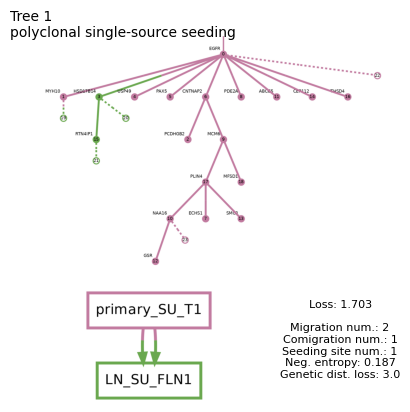

/lila/data/morrisq/divyak/projects/metient/metient/util/vertex_labeling_util.py:280: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)


CRUK0010
5 unique trees were not found (3 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

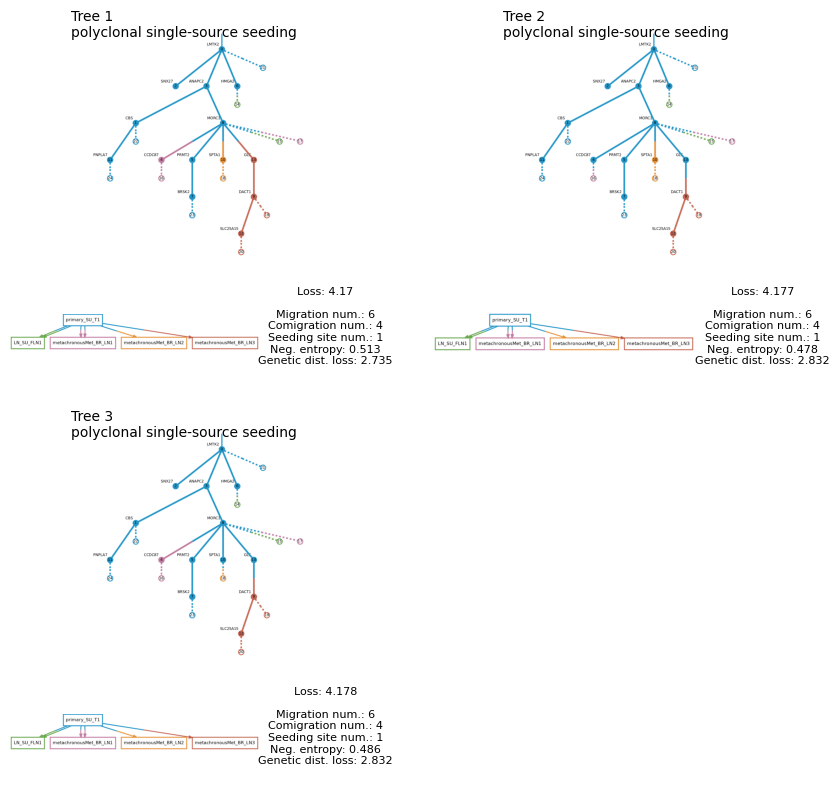

CRUK0013
5 unique trees were not found (1 was found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

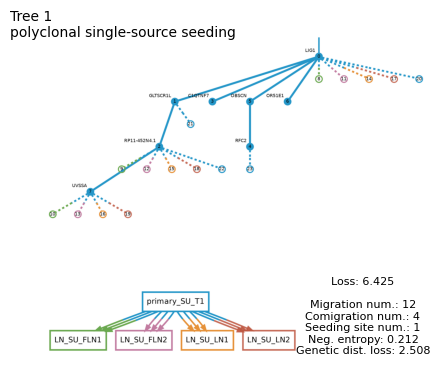

CRUK0029
5 unique trees were not found (3 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

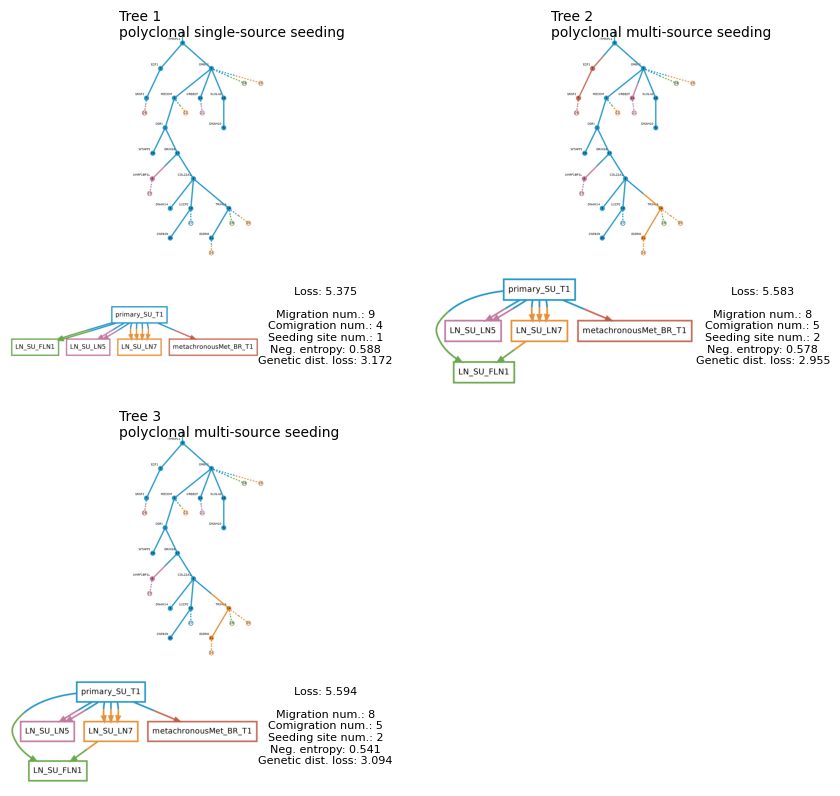

[0.38448894023895264, 0.3077555298805237, 0.3077555298805237]

In [6]:
weights = met.Weights(gen_dist=0.1)
print_config = met.PrintConfig(visualize=True, verbose=False, k_best_trees=5)
met.calibrate(adj_matrices, ref_matrices, var_matrices, ordered_sites, primary_sites, idx_to_label_dicts,
              weights, print_config, os.getcwd(), patients, Gs=gen_dist_matrices, batch_size=500)
